# Test to ensure modifications to function do not change evaluated value

I have written functions for Heaviside and Bessel functions (only first-kind, zero-order) and extended the Bessel function series to eight terms.

A lot of steps have been broken into smaller steps for CUDA to understand it.

In [3]:
import math
from numba import cuda
import ZMCIntegral
import time
import numpy as np
import scipy
import scipy.special
from scipy.integrate import quad

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

Define constants in function

In [4]:
mu = 0.1  # Fermi-level
hOmg = 0.5  # Photon energy eV
a = 4  # AA
A = 4  # hbar^2/(2m)=4 evAA^2 (for free electron mass)
rati = 0.3  # ratio
eE0 = rati * ((hOmg) ** 2) / (2 * np.sqrt(A * mu))
# print(eE0)
Gamm = 0.005  # Gamma in eV.
KT = 1 * 10 ** (-6)
shift = A * (eE0 / hOmg) ** 2

Function given with major modifications. I replaced all calls to kx, ky, qx, and qy with x[0], x[1], x[2], and x[3] respectively. This modification effectively "vectorizes" the input. I have written my own Bessel of first-kind function and Heaviside function to cast into CUDA.

These modifications, however, have made the function only apply to this single case. Extending the ability will take more effort, but can be done with time. Analysis of how well this modified function evaluates to the proper value is below.

Commented out lines are those which I changed, and there should be explanations or some clarity on the changes.

In [5]:
sing = np.array([0.])

def my_heaviside(z): 
    # Wrote this Heaviside expression with it cast in cuda to avoid error below.
    if z <= 0 :
	    return 0
    else :
	    return 1

def my_Bessel(z):
    # CHANGE FOR v4: Changing polynomial evaluation for efficiency (SEE Horner's Algorithm). Extending number of terms.
    # Carrying the series to eight terms ensures that the error in the series is < machine_epsilon when z < 1. 
    # Approximately: z1 <~ 2.1, z2 <~ 3.33  implies  error <~ 2.15E-6 for Bessel. Total averror calculated to be E-16
    val = z**2 / 4 * (-1 + z**2 / 16 * (1 + z**2 / 36 * (-1 + z**2 / 64 * (1 + z**2 / 100 * (-1 + z**2 / 144 * (1 + z**2 / 196 * (-1 + z**2 / 256)))))))
    return val + 1

def modDs_real(x):
    dds = 0
    ek = A * (math.sqrt((x[0]) ** 2 + (x[1]) ** 2)) ** 2 + A * (eE0 / hOmg) ** 2
    ekq = A * (math.sqrt((x[0] + x[2]) ** 2 + (x[1] + x[3]) ** 2)) ** 2 + A * (eE0 / hOmg) ** 2
    xk = 2 * A * eE0 * math.sqrt((x[0]) ** 2 + (x[1]) ** 2) / hOmg ** 2
    xkq = 2 * A * eE0 * math.sqrt((x[0] + x[2]) ** 2 + (x[1] + x[3]) ** 2) / hOmg ** 2

    ts1 = ek - hOmg / 2
    ts2 = ekq - hOmg / 2
    ts3 = ek + hOmg / 2
    ts4 = ekq + hOmg / 2

    arc2ts1 = math.atan2(Gamm, ts1)
    arc2ts2 = math.atan2(Gamm, ts2)
    arc2ts3 = math.atan2(Gamm, ts3)
    arc2ts4 = math.atan2(Gamm, ts4)

    taninv1kp = 2 * arc2ts1
    taninv1kqp = 2 * arc2ts2
    taninv1km = 2 * arc2ts3
    taninv1kqm = 2 * arc2ts4

    squared1 = ek - hOmg/2
    squared2 = ekq - hOmg/2
    squared3 = ek + hOmg/2
    squared4 = ekq + hOmg/2

    logged1 = Gamm**2 + squared1**2
    logged2 = Gamm**2 + squared2**2
    logged3 = Gamm**2 + squared3**2
    logged4 = Gamm**2 + squared4**2

    logged1 = Gamm**2 + (ek - hOmg/2)**2
    logged2 = Gamm**2 + (ekq - hOmg/2)**2
    logged3 = Gamm**2 + (ek + hOmg/2)**2
    logged4 = Gamm**2 + (ekq + hOmg/2)**2

    ln1 = math.log(logged1)
    ln2 = math.log(logged2)
    ln3 = math.log(logged3)
    ln4 = math.log(logged4)

    lg1kp = complex(0, 1) * ln1
    lg1kqp = complex(0, 1) * ln2
    lg1km = complex(0, 1) * ln3
    lg1kqm = complex(0, 1) * ln4
	
    heavi1 = mu - hOmg / 2
    heavi2 = mu + hOmg / 2

    ferp = my_heaviside(heavi1)
    ferm = my_heaviside(heavi2)

    taninv2k = 2 * math.atan2(Gamm, ek - mu)
    taninv2kq = 2 * math.atan2(Gamm, ekq - mu)

    lg2k = complex(0, 1) * math.log(Gamm ** 2 + (ek - mu) ** 2)
    lg2kq = complex(0, 1) * math.log(Gamm ** 2 + (ekq - mu) ** 2)

    besk = my_Bessel(xk)
    beskq = my_Bessel(xkq)

    fac1 = ek - ekq

    fac2 = fac1 + 2 * complex(0, 1) * Gamm
    fac3 = fac2 - ek + ekq


    # NOTE: N = 1 implies all loops below will be evaluated once.
    p1p = fac1 * (taninv1kp - taninv2k - lg1kp + lg2k)
    p2p = fac2 * (taninv1kp - taninv2k + lg1kp - lg2k)
    p3p = fac3 * (-taninv1kqp + taninv2kq - lg1kqp + lg2kq)

    p1m = fac1 * (taninv1km - taninv2k - lg1km + lg2k)
    p2m = fac2 * (taninv1km - taninv2k + lg1km - lg2k)
    p3m = fac3 * (-taninv1kqm + taninv2kq - lg1kqm + lg2kq)

    d1 = -2 * complex(0, 1) * fac1 * fac2 * fac3

    omint1p = ferp * ((p1p + p2p + p3p) / d1)
    omint1m = ferm * ((p1m + p2m + p3m) / d1)

    bess1 = beskq * beskq * besk * besk * besk * besk

    grgl = bess1 * (omint1p - omint1m)

    pp1p = fac1 * (-taninv1kqp + taninv2kq - lg1kqp + lg2kq)
    pp2p = fac2 * (-taninv1kqp + taninv2kq + lg1kqp - lg2kq)
    pp3p = fac3 * (taninv1kp - taninv2k - lg1kp + lg2k)

    pp1m = fac1 * (-taninv1kqm + taninv2kq - lg1kqm + lg2kq)
    pp2m = fac2 * (-taninv1kqm + taninv2kq + lg1kqm - lg2kq)

    pp3m = fac3 * (taninv1km - taninv2k - lg1km + lg2k)

    d2 = -2 * complex(0, 1) * fac1 * fac2 * fac3

    omint2p = ferp * ((pp1p + pp2p + pp3p) / d2)
    omint2m = ferm * ((pp1m + pp2m + pp3m) / d2)

    bess2 = beskq * beskq * beskq * beskq * besk * besk

    glga = bess2 * (omint2p - omint2m)

    dds = dds + 2 * Gamm * (grgl + glga)

    return dds.real # / (8*math.pi**3)


The original function is declared below.

In [6]:
def Ds(kx, ky, qx, qy):
    N = 1
    dds = 0
    ds = 0
    ek = A * (math.sqrt((kx) ** 2 + (ky) ** 2)) ** 2 + A * (eE0 / hOmg) ** 2
    ekq = A * (math.sqrt((kx + qx) ** 2 + (ky + qy) ** 2)) ** 2 + A * (eE0 / hOmg) ** 2
    xk = 2 * A * eE0 * math.sqrt((kx) ** 2 + (ky) ** 2) / hOmg ** 2
    xkq = 2 * A * eE0 * math.sqrt((kx + qx) ** 2 + (ky + qy) ** 2) / hOmg ** 2

    sing = np.arange(-(N - 1) / 2, (N - 1) / 2 + 1, 1)
    taninv1kp = 2 * np.arctan2(Gamm, ek - hOmg / 2 + hOmg * sing)
    taninv1kqp = 2 * np.arctan2(Gamm, ekq - hOmg / 2 + hOmg * sing)
    taninv1km = 2 * np.arctan2(Gamm, ek + hOmg / 2 + hOmg * sing)
    taninv1kqm = 2 * np.arctan2(Gamm, ekq + hOmg / 2 + hOmg * sing)

    lg1kp = complex(0, 1) * np.log(Gamm ** 2 + (ek - hOmg / 2 + hOmg * sing) ** 2)
    lg1kqp = complex(0, 1) * np.log(Gamm ** 2 + (ekq - hOmg / 2 + hOmg * sing) ** 2)
    lg1km = complex(0, 1) * np.log(Gamm ** 2 + (ek + hOmg / 2 + hOmg * sing) ** 2)
    lg1kqm = complex(0, 1) * np.log(Gamm ** 2 + (ekq + hOmg / 2 + hOmg * sing) ** 2)

    ferp = np.heaviside(mu - hOmg / 2 - hOmg * sing, 0)
    ferm = np.heaviside(mu + hOmg / 2 - hOmg * sing, 0)

    dbl = np.arange(-(N - 1), (N - 1) + 1, 1)
    taninv2k = 2 * np.arctan2(Gamm, ek - mu + hOmg * dbl)
    taninv2kq = 2 * np.arctan2(Gamm, ekq - mu + hOmg * dbl)

    lg2k = complex(0, 1) * np.log(Gamm ** 2 + (ek - mu + hOmg * dbl) ** 2)
    lg2kq = complex(0, 1) * np.log(Gamm ** 2 + (ekq - mu + hOmg * dbl) ** 2)

    besk = scipy.special.jv(dbl, xk)
    beskq = scipy.special.jv(dbl, xkq)

    fac1 = ek - ekq + hOmg * dbl
    fac2 = fac1 + 2 * complex(0, 1) * Gamm
    fac3 = fac2 - ek + ekq

    for n in range(0, N):
        for alpha in range(0, N):
            for beta in range(0, N):
                for gamma in range(0, N):
                    for s in range(0, N):
                        for l in range(0, N):
                            p1p = fac1[beta - gamma + N - 1] * (
                                    taninv1kp[alpha] - taninv2k[s + alpha] - lg1kp[alpha] + lg2k[s + alpha])
                            p2p = fac2[alpha - gamma + N - 1] * (
                                    taninv1kp[beta] - taninv2k[s + beta] + lg1kp[beta] - lg2k[s + beta])
                            p3p = fac3[alpha - beta + N - 1] * (
                                    -taninv1kqp[gamma] + taninv2kq[s + gamma] - lg1kqp[gamma] + lg2kq[
                                s + gamma])

                            p1m = fac1[beta - gamma + N - 1] * (
                                    taninv1km[alpha] - taninv2k[s + alpha] - lg1km[alpha] + lg2k[s + alpha])

                            p2m = fac2[alpha - gamma + N - 1] * (
                                    taninv1km[beta] - taninv2k[s + beta] + lg1km[beta] - lg2k[s + beta])

                            p3m = fac3[alpha - beta + N - 1] * (
                                    -taninv1kqm[gamma] + taninv2kq[s + gamma] - lg1kqm[gamma] + lg2kq[
                                s + gamma])

                            d1 = -2 * complex(0, 1) * fac1[beta - gamma + N - 1] * fac2[alpha - gamma + N - 1] * \
                                 fac3[
                                     alpha - beta + N - 1]

                            omint1p = ferp[s] * ((p1p + p2p + p3p) / d1)

                            omint1m = ferm[s] * ((p1m + p2m + p3m) / d1)

                            bess1 = beskq[gamma - n + N - 1] * beskq[gamma - l + N - 1] * besk[beta - l + N - 1] * besk[
                                beta - s + N - 1] * besk[alpha - s + N - 1] * besk[alpha - n + N - 1]

                            grgl = bess1 * (omint1p - omint1m)

                            pp1p = fac1[alpha - beta + N - 1] * (
                                    -taninv1kqp[gamma] + taninv2kq[s + gamma] - lg1kqp[gamma] + lg2kq[
                                s + gamma])

                            pp2p = fac2[alpha - gamma + N - 1] * (
                                    -taninv1kqp[beta] + taninv2kq[s + beta] + lg1kqp[beta] - lg2kq[
                                s + beta])

                            pp3p = fac3[beta - gamma + N - 1] * (
                                    taninv1kp[alpha] - taninv2k[s + alpha] - lg1kp[alpha] + lg2k[s + alpha])

                            pp1m = fac1[alpha - beta + N - 1] * (
                                    -taninv1kqm[gamma] + taninv2kq[s + gamma] - lg1kqm[gamma] + lg2kq[
                                s + gamma])

                            pp2m = fac2[alpha - gamma + N - 1] * (
                                    -taninv1kqm[beta] + taninv2kq[s + beta] + lg1kqm[beta] - lg2kq[
                                s + beta])

                            pp3m = fac3[beta - gamma + N - 1] * (
                                    taninv1km[alpha] - taninv2k[s + alpha] - lg1km[alpha] + lg2k[s + alpha])

                            d2 = -2 * complex(0, 1) * fac1[alpha - beta + N - 1] * fac2[alpha - gamma + N - 1] * \
                                 fac3[
                                     beta - gamma + N - 1]

                            omint2p = ferp[s] * ((pp1p + pp2p + pp3p) / d2)

                            omint2m = ferm[s] * ((pp1m + pp2m + pp3m) / d2)

                            bess2 = beskq[gamma - n + N - 1] * beskq[gamma - s + N - 1] * beskq[beta - s + N - 1] * \
                                    beskq[beta - l + N - 1] * besk[alpha - l + N - 1] * besk[alpha - n + N - 1]

                            glga = bess2 * (omint2p - omint2m)

                            dds = dds + 2 * Gamm * (grgl + glga)
    return dds

In [7]:
# Make error array.
relerror = np.zeros(27)

print('Comparing modified version and original')
print('================================================================================================')
print(' kx  | ky  | qx  | qy  | Ds          | modDs  ')
print('================================================================================================')
for i in range(0, 3, 1):
    for j in range(0, 3, 1):
        for k in range(1, 4, 1):
            xin = [i/10, j/10, k/10, 0]
            ds_result = Ds(i/10, j/10, k/10, 0).real
            modds_result = modDs_real(xin)
            print('%2.1f  | %2.1f | %2.1f | 0   |'%(i/10, j/10, k/10), ds_result, ' | ', modds_result)
            relerror[i+j+k-1] = abs((modds_result / ds_result.real) - 1)
            

Comparing modified version and original
 kx  | ky  | qx  | qy  | Ds          | modDs  
0.0  | 0.0 | 0.1 | 0   | -41.86649926328053  |  -41.86649926328055
0.0  | 0.0 | 0.2 | 0   | -34.63780146737251  |  -34.63780146737251
0.0  | 0.0 | 0.3 | 0   | -14.134014421216573  |  -14.134014421216571
0.0  | 0.1 | 0.1 | 0   | -96.43684721789926  |  -96.43684721789921
0.0  | 0.1 | 0.2 | 0   | -23.91771505962262  |  -23.917715059622612
0.0  | 0.1 | 0.3 | 0   | -9.746602862432903  |  -9.7466028624329
0.0  | 0.2 | 0.1 | 0   | -0.39732541568738206  |  -0.39732541568738206
0.0  | 0.2 | 0.2 | 0   | -0.20160348539836384  |  -0.20160348539836392
0.0  | 0.2 | 0.3 | 0   | -0.1007749790160859  |  -0.1007749790160859
0.1  | 0.0 | 0.1 | 0   | -32.33742271129596  |  -32.337422711295936
0.1  | 0.0 | 0.2 | 0   | -11.16701307138729  |  -11.167013071387283
0.1  | 0.0 | 0.3 | 0   | -5.221550809191184  |  -5.221550809191182
0.1  | 0.1 | 0.1 | 0   | -1.423292938420817  |  -1.423292938420817
0.1  | 0.1 | 0.2 | 0   | -0.5

In [8]:
errorsum = 0
print('Comparing modified version and original')
print('================================================================================================')
print(' kx  | ky  | qx  | qy  | rel error  ')
print('================================================================================================')
for i in range(0, 3, 1):
    for j in range(0, 3, 1):
        for k in range(1, 4, 1):
            print('%2.1f  | %2.1f | %2.1f | 0   |'%(i/10, j/10, k/10), relerror[i+j+k-1])
            errorsum = errorsum + relerror[i+j+k-1]
           
avgerror = errorsum / (27)            
print('================================================================================================')
print('The average error of modified function is ', avgerror)

Comparing modified version and original
 kx  | ky  | qx  | qy  | rel error  
0.0  | 0.0 | 0.1 | 0   | 4.440892098500626e-16
0.0  | 0.0 | 0.2 | 0   | 6.661338147750939e-16
0.0  | 0.0 | 0.3 | 0   | 0.0
0.0  | 0.1 | 0.1 | 0   | 6.661338147750939e-16
0.0  | 0.1 | 0.2 | 0   | 0.0
0.0  | 0.1 | 0.3 | 0   | 2.220446049250313e-16
0.0  | 0.2 | 0.1 | 0   | 0.0
0.0  | 0.2 | 0.2 | 0   | 2.220446049250313e-16
0.0  | 0.2 | 0.3 | 0   | 4.440892098500626e-16
0.1  | 0.0 | 0.1 | 0   | 6.661338147750939e-16
0.1  | 0.0 | 0.2 | 0   | 0.0
0.1  | 0.0 | 0.3 | 0   | 2.220446049250313e-16
0.1  | 0.1 | 0.1 | 0   | 0.0
0.1  | 0.1 | 0.2 | 0   | 2.220446049250313e-16
0.1  | 0.1 | 0.3 | 0   | 4.440892098500626e-16
0.1  | 0.2 | 0.1 | 0   | 2.220446049250313e-16
0.1  | 0.2 | 0.2 | 0   | 4.440892098500626e-16
0.1  | 0.2 | 0.3 | 0   | 8.881784197001252e-16
0.2  | 0.0 | 0.1 | 0   | 0.0
0.2  | 0.0 | 0.2 | 0   | 2.220446049250313e-16
0.2  | 0.0 | 0.3 | 0   | 4.440892098500626e-16
0.2  | 0.1 | 0.1 | 0   | 2.220446049250313e-

# Checking the plots of Ds(kx,ky) at different values of qx

Below I set up the input for the plotting with qx = 0.01. (qy=0 in all cases)

In [9]:
spacing = 500
Z = np.zeros([spacing,spacing])

# Make data.
X = np.linspace(-.785, .785, spacing)
Y = np.linspace(-.785, .785, spacing)
X, Y = np.meshgrid(X, Y)
# Z = modDs_real([X, Y, 0.01, 0])

l = 0 
k = 0
for i in np.linspace(-.785, .785, spacing):
    for j in np.linspace(-.785, .785, spacing):
        Z[l][k] = modDs_real([i, j, 0.01, 0])
        k = k + 1
    l = l + 1
    k = 0


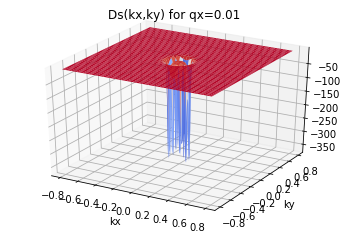

In [10]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = plt.axes(projection='3d')
# Plot the surface.
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
plt.title('Ds(kx,ky) for qx=0.01')
plt.xlabel('kx')
plt.ylabel('ky')

plt.show()

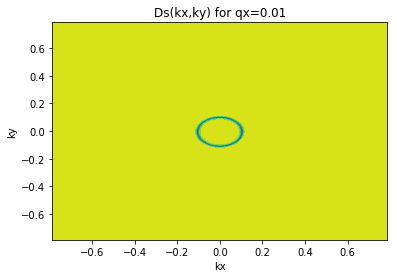

In [11]:
ax1 = plt.contourf(X,Y,Z)
plt.title('Ds(kx,ky) for qx=0.01')
plt.xlabel('kx')
plt.ylabel('ky')

plt.show()

Now for qx = 0.5:

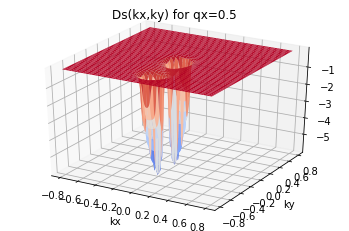

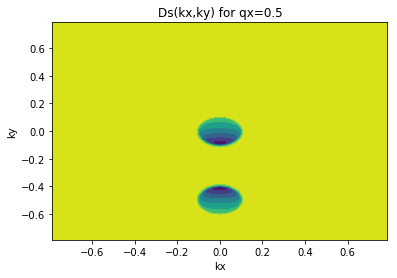

In [12]:
l = 0 
k = 0
for i in np.linspace(-.785, .785, spacing):
    for j in np.linspace(-.785, .785, spacing):
        Z[l][k] = modDs_real([i, j, 0.5, 0])
        k = k + 1
    l = l + 1
    k = 0
    
fig = plt.figure()
ax = plt.axes(projection='3d')
# Plot the surface.
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
plt.title('Ds(kx,ky) for qx=0.5')
plt.xlabel('kx')
plt.ylabel('ky')

plt.show()

ax1 = plt.contourf(X,Y,Z)
plt.title('Ds(kx,ky) for qx=0.5')
plt.xlabel('kx')
plt.ylabel('ky')

plt.show()

# Plotting of integrand of Ds(kx,ky) for series of qx

The integral was evaluated with: kx = \[-pi/a,pi/a\], ky = \[-pi/a,pi/a\].
(qy = 0 in all cases)
Monte Carlo did not like using step size h = .001 in qx = \[qxi, qxi+h\] or keeping qx constant when an input. The step size is therefore h = .05 in the expression above.

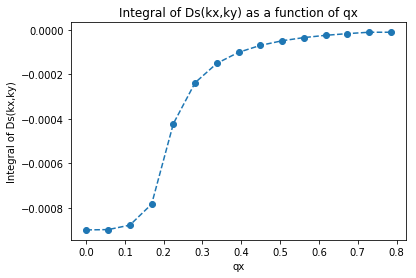

In [19]:
Ds_intresults = [-0.0008998947983862685, -0.0008984870875941153, -0.0008783269817484231, -0.0007840258947021157, 
                 -0.00042225297194019366, -0.0002382468444182257, -0.00015139070885043123, -0.00010179404910837399,
                 -7.066049425279921e-05, -4.994442346765877e-05, -3.561460332601186e-05, -2.542833253521957e-05,
                 -1.7833215612822982e-05, -1.1587536146806069e-05, -1.1587536146806069e-05]

qxi = [.001, .057, .113, .169, .225, .281, .337, .393, .449, .505, .561, .617, .673, .729, .785]

plt.plot(qxi, Ds_intresults, marker='o', linestyle='dashed')
plt.title('Integral of Ds(kx,ky) as a function of qx')
plt.xlabel('qx')
plt.ylabel('Integral of Ds(kx,ky)')

plt.show()
